# GIS to get latitude and longitude for cities using python

# Provide the spacing here
1 degree = approx. 111km

In [1]:
space_range = 5       #in km


In [2]:
#convert km to degrees
space_deg = space_range *90/10000
space_deg

0.045

In [3]:
#Import libraries
from geopy.geocoders import Nominatim
import folium
import json
import numpy as np
import requests
import pandas as pd
import geopandas as gpd
import json
from shapely.geometry import Point
from shapely.ops import cascaded_union
import matplotlib.pyplot as plt



#### Create dataframe from the json file provided  - for the first country in list - Mexico

In [4]:
#**************** Read json file ********************
with open('city_list.json') as f:
    cities = json.load(f)
print(print(cities.keys()))
print(cities['data'].keys())
print(cities['data']['countryList'][0]['countryName'])
print(cities['data']['countryList'][0].keys())
print(cities['data']['countryList'][0]['cities'][0].keys())


dict_keys(['errno', 'errmsg', 'time', 'data', 'requestId', 'traceId'])
None
dict_keys(['countryList'])
Mexico
dict_keys(['countryCode', 'countryName', 'cities'])
dict_keys(['cityId', 'cityName', 'hotPoi'])


In [5]:
# **********  Form a dataframe from json **************

pd.set_option('display.max_rows', 10)
lstcity = []   #Initialize a list
id=0
for city in cities['data']['countryList'][0]['cities']:
    id += 1
    if 'name' in city['hotPoi']:
        nm = city['hotPoi']['name']
    else:
        nm=''
        
    lstcity.append([ (city['cityId'],
                      city['cityName'],
        city['hotPoi']['lat'],
        city['hotPoi']['lng'],
        nm
                     )])
    
dfcity = pd.DataFrame([item for lstcity in lstcity for item in lstcity])    #Create dataframe from list
dfcity.columns = ['CityId', 'CityName' , 'Latitude', 'Longitude', 'Address']
dfcity  =dfcity.sort_values(['Latitude'])
dfcity.head()

,CityId,CityName,Latitude,Longitude,Address
51,52070900,Tapachula,14.905557,-92.263414,MX Tapachula
45,52070800,San Cristobal de las Casas,16.737036,-92.637619,MX San Cristobal de las Casas
58,52071100,Tuxtla Gutierrez,16.751601,-93.102994,MX Tuxtla Gutierrez
0,52120200,Acapulco,16.853109,-99.823653,"Luis Donaldo Colosio, El Coloso, Acapulco de J..."
38,52200100,Oaxaca,17.073184,-96.726589,MX 瓦哈卡


### Plot the hotpoints and city boundaries using folium map

In [6]:
#*********** plot the hotpoint of cities ************
#Let us first do it for 'Mexico' - get lat and long for 'mexico'

geolocator = Nominatim(user_agent = "myproj")
location = geolocator.geocode("Mexico")
conlat = location.latitude
conlng = location.longitude
print('Mexico - Latitude and Longitude:')
print(conlat,conlng)

map_city = folium.Map(location = [conlat, conlng],zoom_start =5 )

#Now mark the cities

#Add title to the map
title_html = '''<h3 align="center" style="font-size:20px"><b>
        Mexico - Hot points and city boundaries</b></h3>'''
map_city.get_root().html.add_child(folium.Element(title_html))

#*********** Now mark the boundaries of the cities *************
#Use geojson file for 'mexico' to draw outlies
folium.GeoJson("mexico.geojson", name = 'Mexico').add_to(map_city)

#Add markers that shows the hotpoints
for lat,lng,label in zip(dfcity['Latitude'],dfcity['Longitude'],dfcity['CityName']):
 
    label = folium.Popup(label,parse_html = True)
    
    folium.CircleMarker(
        [lat,lng],
        radius = 5,
        popup = label,
        color ='darkred',
        fill = True,
        fill_color = 'darkred',
        fill_opacity = 0.5,
        parse_html = False).add_to(map_city)
map_city

Mexico - Latitude and Longitude:
23.6585116 -102.0077097


### Generate equally spaced geo co-ordinates points for mexico

In [7]:
def generate_grid_in_polygon(spacing, polygon):
    
    ''' polygon - geodataframe, spacing - distance in degrees
        This Function generates evenly spaced points within the given GeoDataFrame.
        The parameter 'spacing' defines the distance between the points in coordinate units. '''
    
    # Convert the GeoDataFrame to a single polygon
    #poly_in = cascaded_union([poly for poly in polygon.geometry])
    poly_in = cascaded_union([poly if poly.is_valid else poly.buffer(0) for poly in polygon.geometry])
    
    # Get the bounds of the polygon
    minx, miny, maxx, maxy = poly_in.bounds    
    
    # Now generate the entire grid
    x_coords = list(np.arange(np.floor(minx), int(np.ceil(maxx)), spacing))
    y_coords = list(np.arange(np.floor(miny), int(np.ceil(maxy)), spacing))
    
    #generate list of points with x and y coords
    grid = [Point(x) for x in zip(np.meshgrid(x_coords, y_coords)[0].flatten(), np.meshgrid(x_coords, y_coords)[1].flatten())]
    
    # Finally only keep the points within the polygon
    list_of_points = [point for point in grid if point.within(poly_in)]

    return list_of_points


In [8]:
#Read shape file into a geodataframe
shape_in = gpd.read_file('mexico_shape/mexico-polygon.shp')


### Loop thorugh the cities and write the points to geojson file

Oaxaca
Puebla
Colima
Tlaxcala
Campeche
Aguascalientes
Zacatecas
Durango
Chihuahua


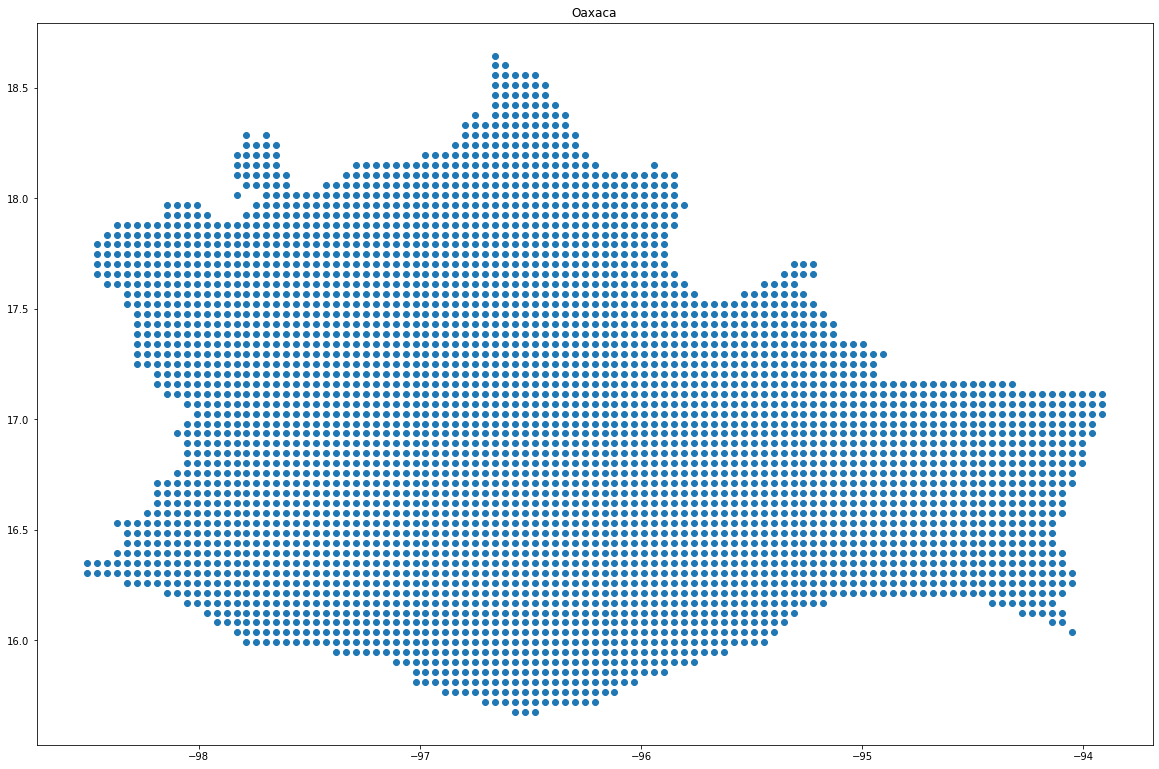

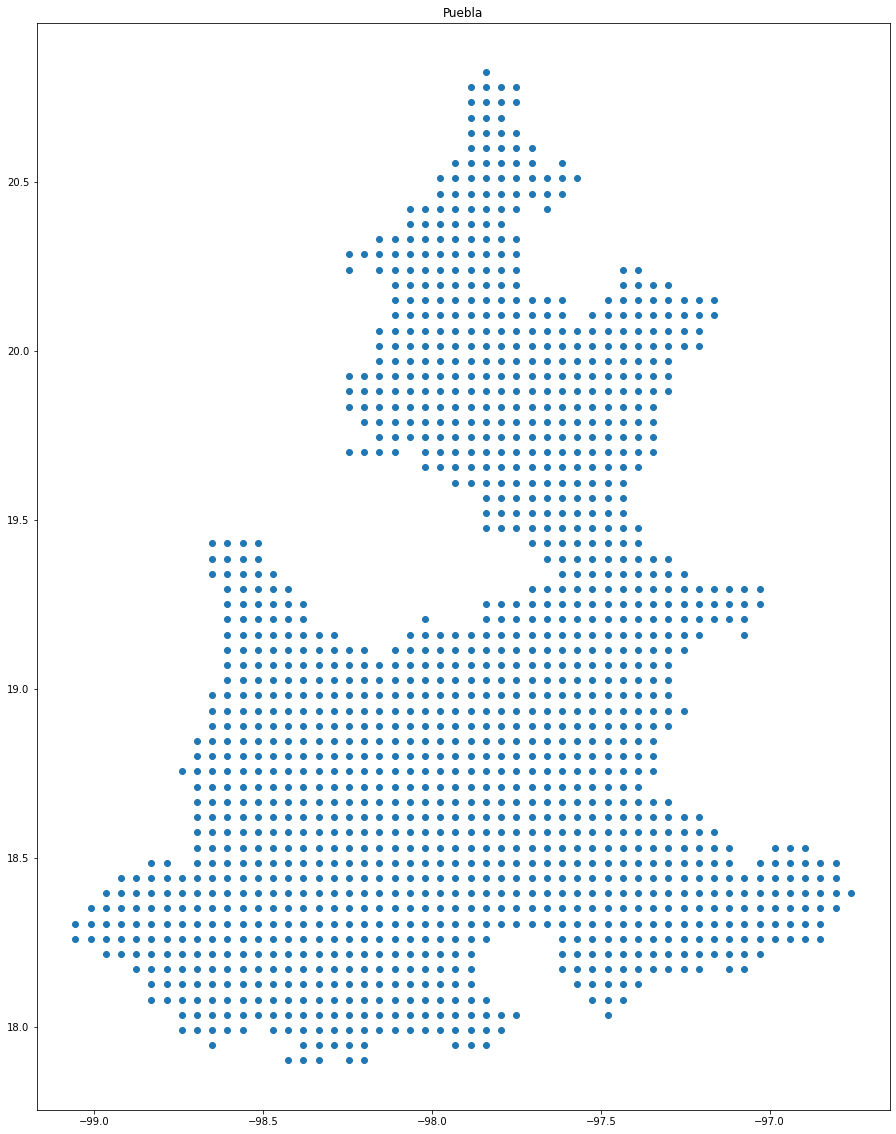

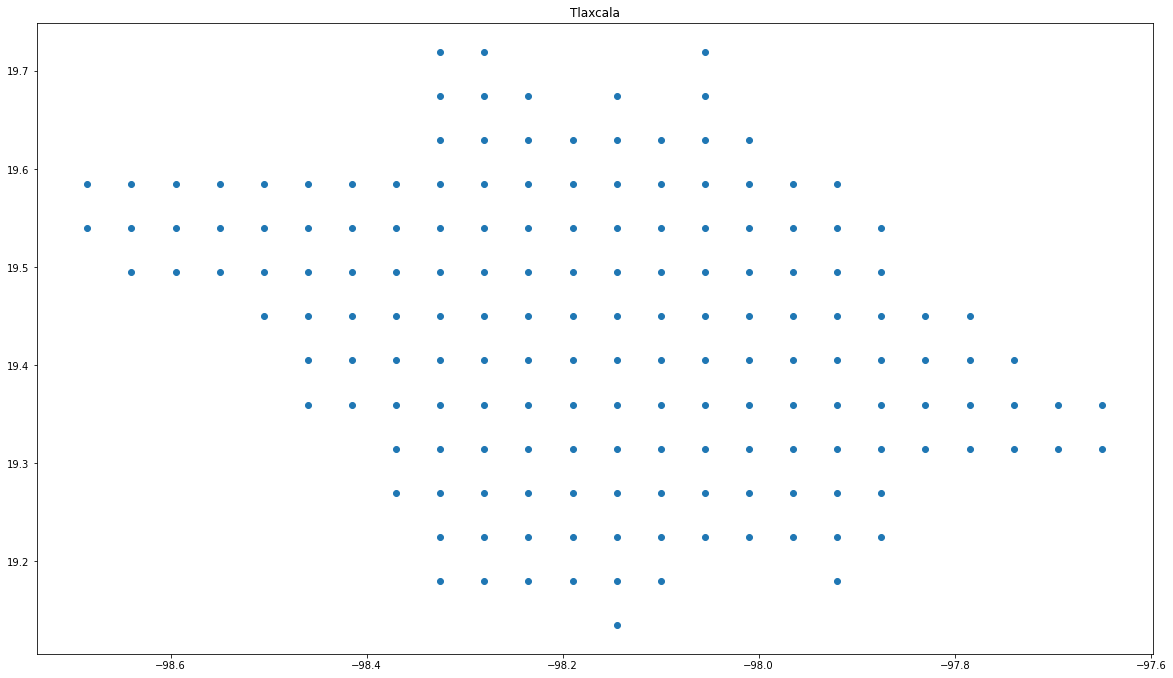

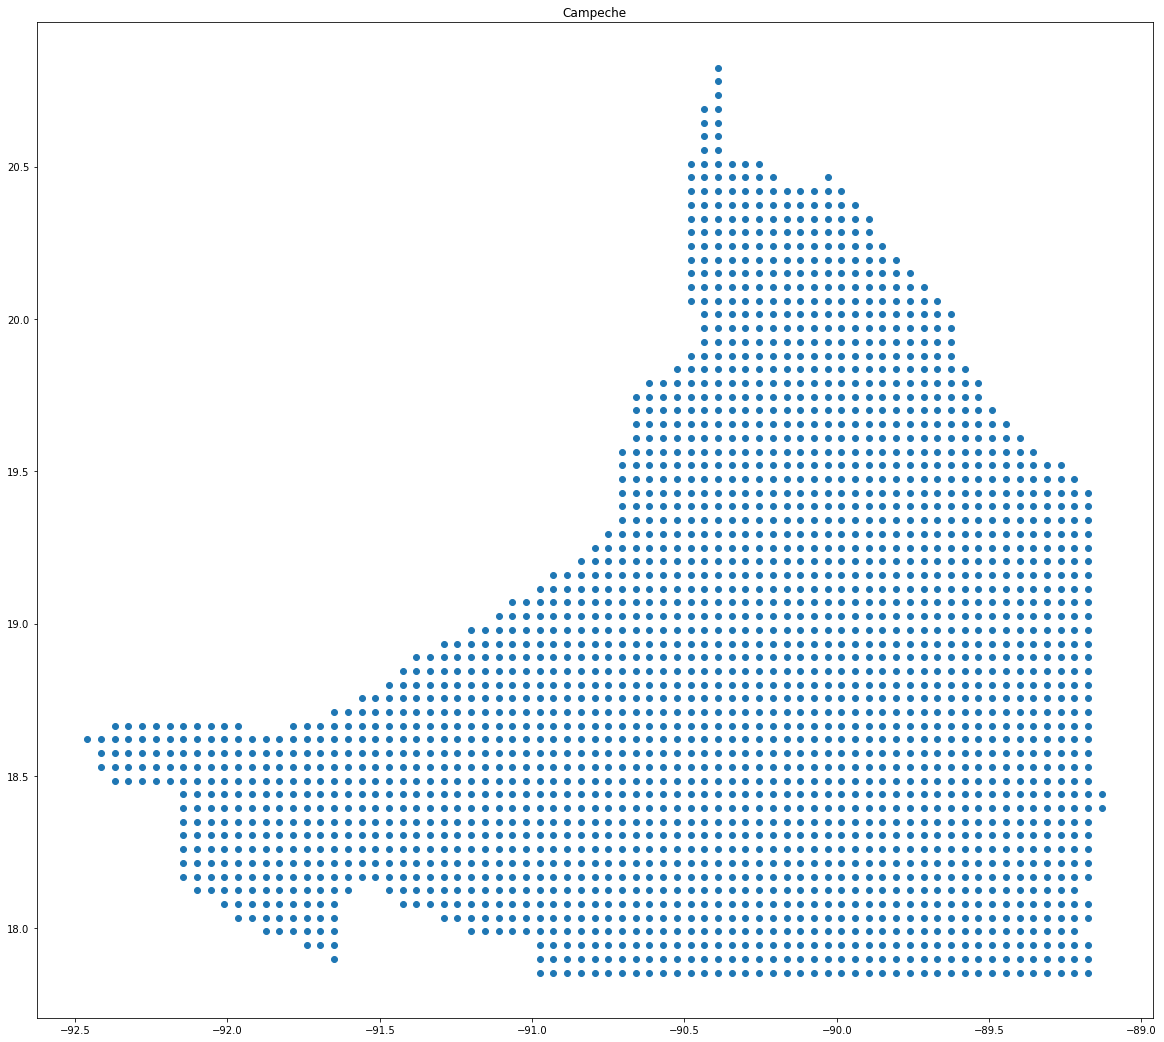

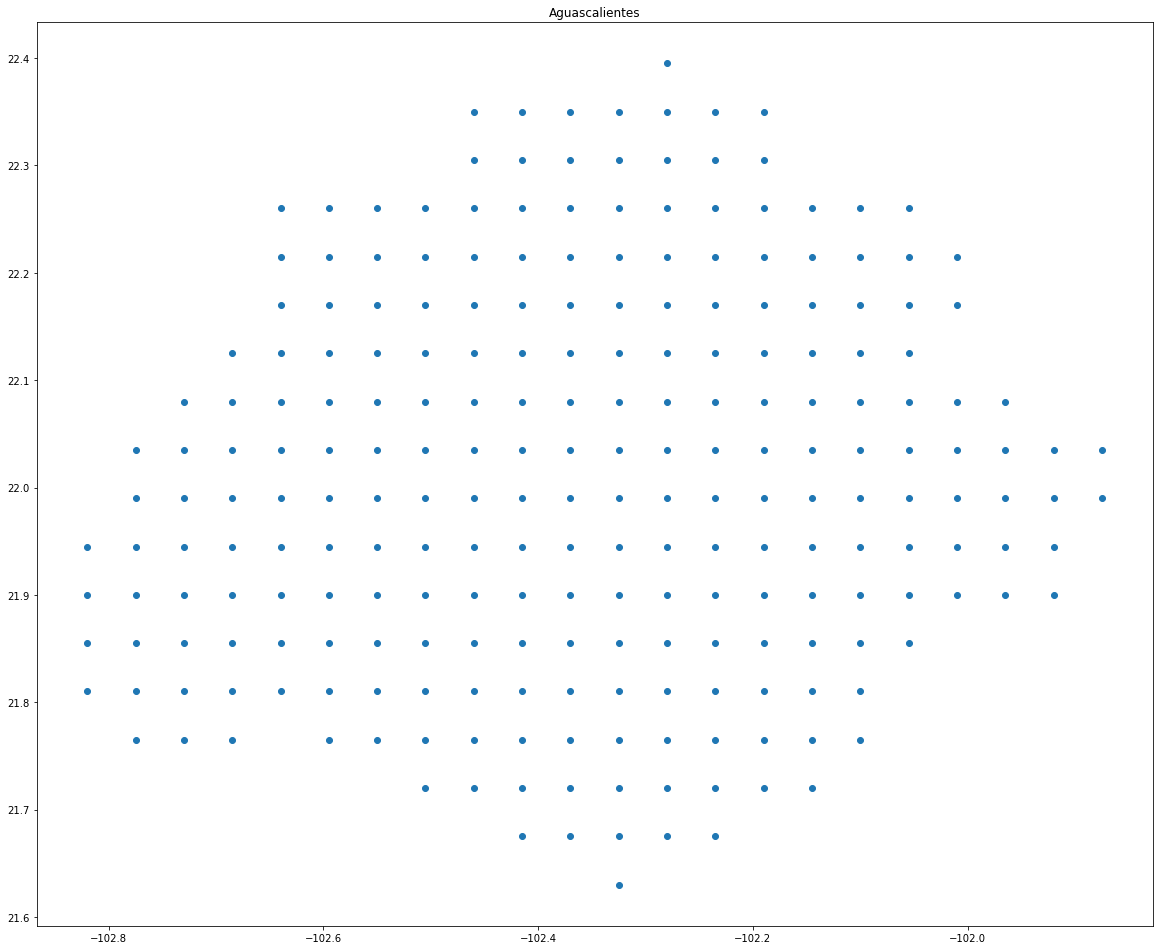

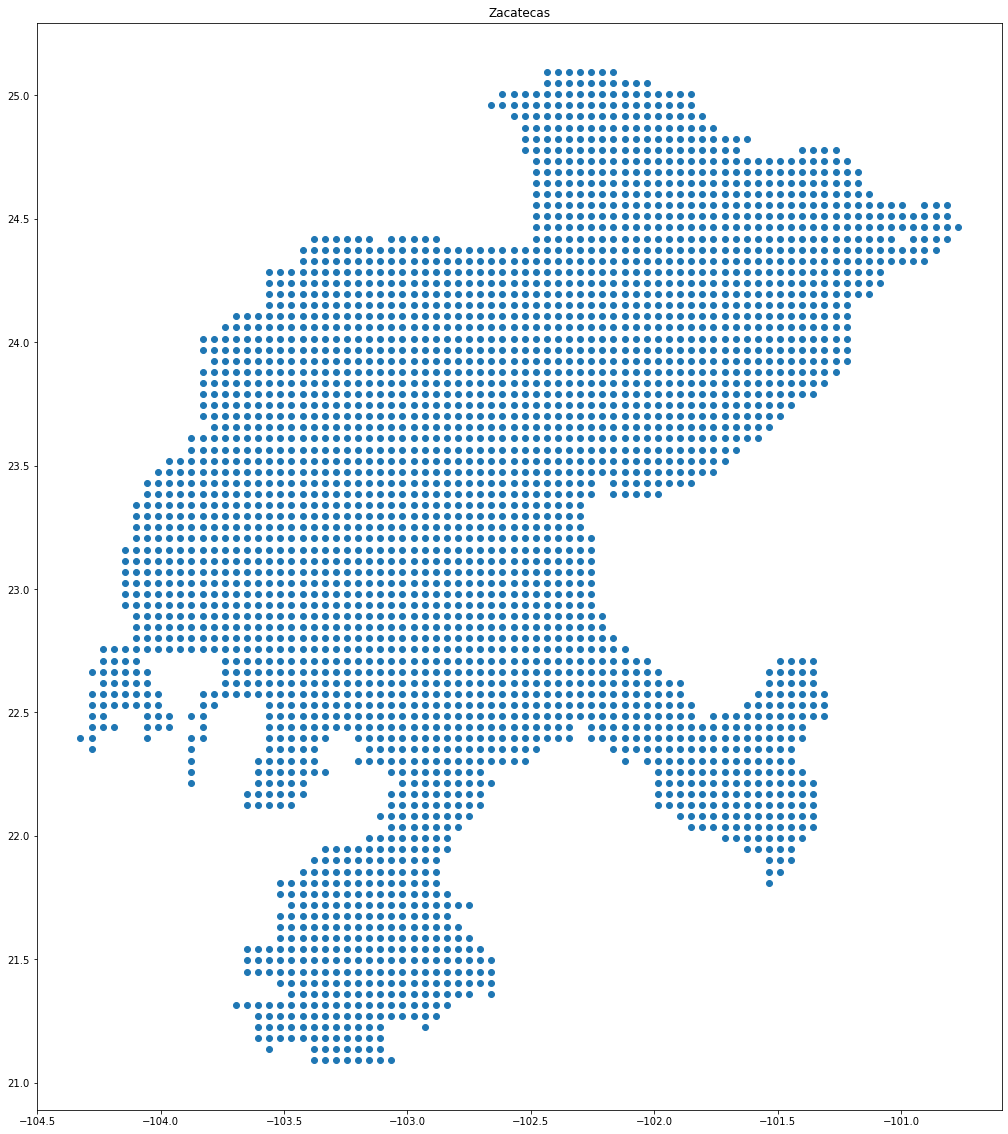

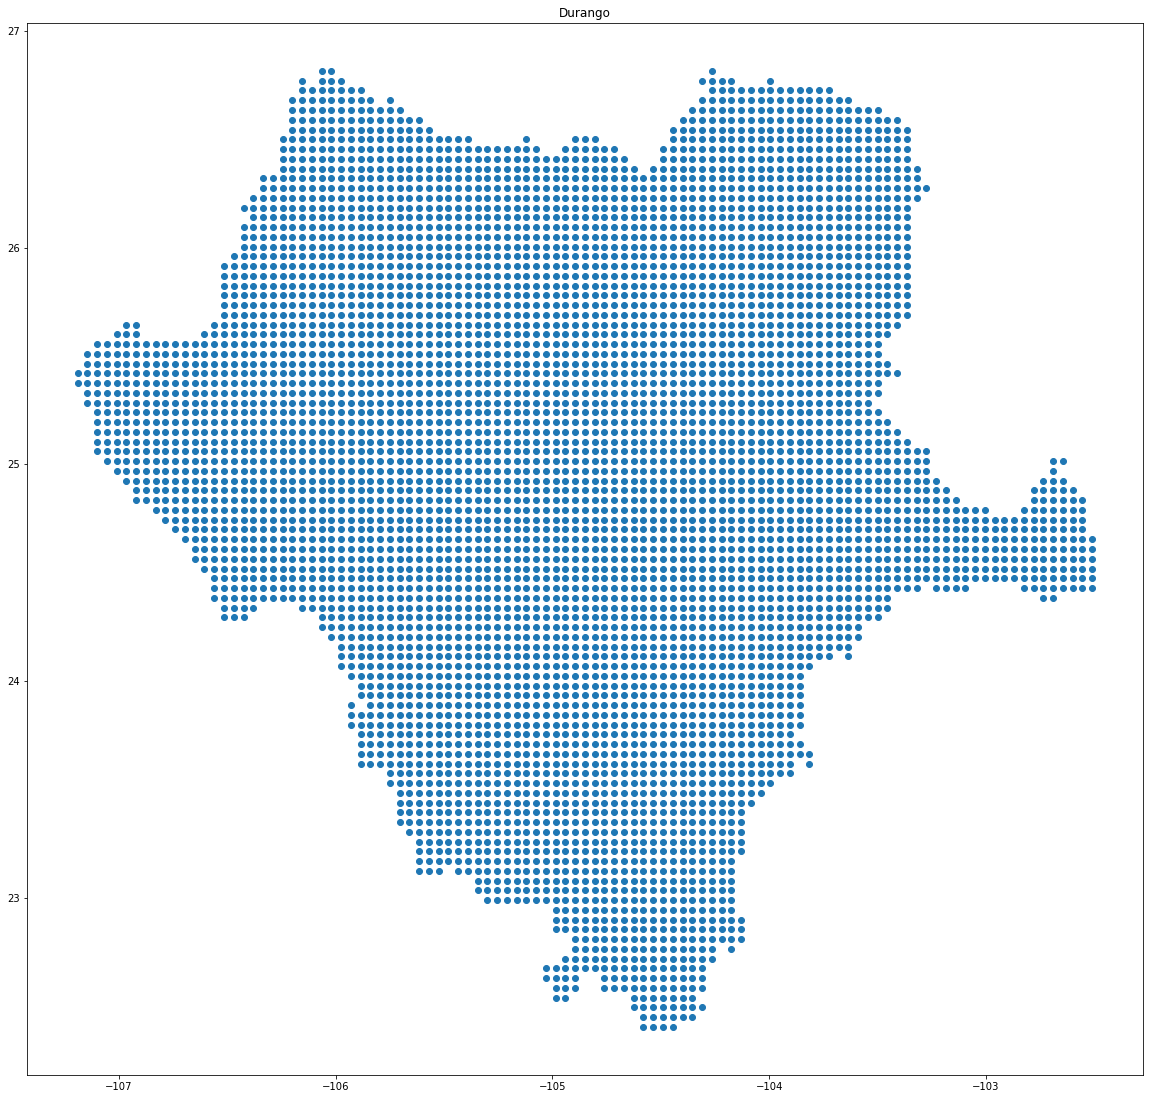

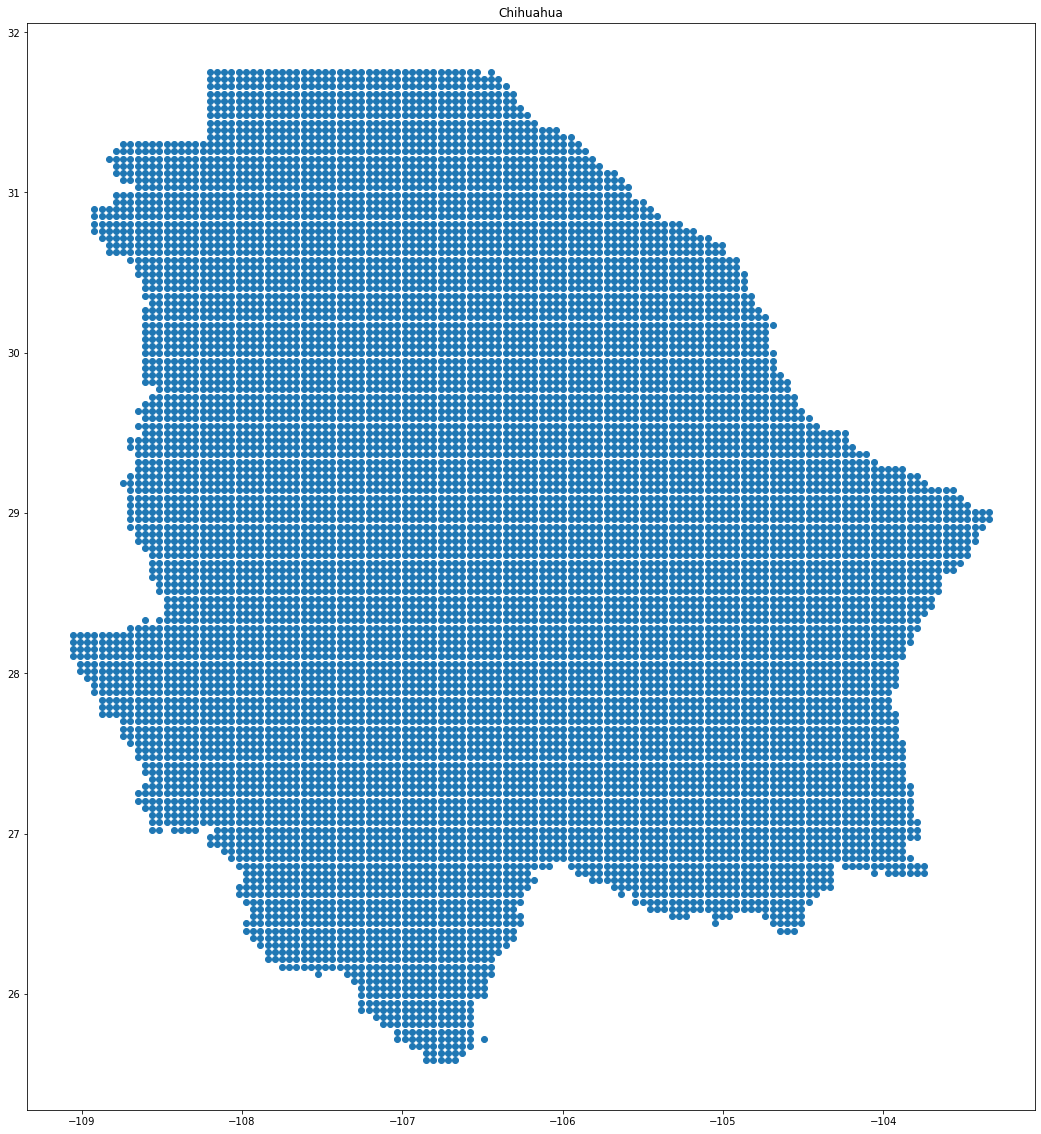

In [9]:

for city in dfcity['CityName'].values:
    dfgeocity = gpd.GeoDataFrame()
    for gcity in shape_in['state_name']:
        if city == gcity:
            print(city)
            dftmp = gpd.GeoDataFrame(shape_in[shape_in['state_name'] == city])
            #remove multipolygon from dataframe
            dfgeocity = dftmp[dftmp.state_code!= 6]
            break
            
    if not dfgeocity.empty:
        
        #Get points inside the given shape - points_in_poly will hold shapely point object
        points_in_poly = generate_grid_in_polygon(space_deg, dfgeocity)
        
        #create geodataframe from points
        points_in_poly_gdf = gpd.GeoDataFrame(geometry=points_in_poly)
        if not points_in_poly_gdf.empty:

            #write the points to geojson file
            points_in_poly_gdf.to_file('outfiles/out_' + gcity + '.json', driver = 'GeoJSON')

            #ax2 = shape_in.plot(ax=ax1, facecolor='yellow', edgecolor='k')
            fig,ax1 = plt.subplots(figsize = (20,20))
            ax1.set_title(city)
            ax2 = points_in_poly_gdf.plot(ax=ax1)

            ax2.figure.savefig('maps\mesh_' + city + '.jpg')

        
